In [175]:
import torch
from keypoint_extractor import keypoint_extractor
from biomechanical_features import BiomechanicalFeatureExtractor

extractor = BiomechanicalFeatureExtractor()
# features = keypoint_extractor('tiktok_data/halfwaylift/first.mp4')
# features = keypoint_extractor('test_data/cobra.mp4')
features = keypoint_extractor('tiktok_data/downwarddog/second.mp4')
# print(features)

Processed 30/641 frames (28.83 fps)
Processed 60/641 frames (35.39 fps)
Processed 90/641 frames (37.47 fps)
Processed 120/641 frames (39.64 fps)
Processed 150/641 frames (41.06 fps)
Processed 180/641 frames (42.05 fps)
Processed 210/641 frames (42.72 fps)
Processed 240/641 frames (43.16 fps)
Processed 270/641 frames (43.46 fps)
Processed 300/641 frames (43.72 fps)
Processed 330/641 frames (43.99 fps)
Processed 360/641 frames (44.21 fps)
Processed 390/641 frames (44.40 fps)
Processed 420/641 frames (44.54 fps)
Processed 450/641 frames (44.71 fps)
Processed 480/641 frames (44.86 fps)
Processed 510/641 frames (44.97 fps)
Processed 540/641 frames (45.09 fps)
Processed 570/641 frames (45.21 fps)
Processed 600/641 frames (45.31 fps)
Processed 630/641 frames (45.41 fps)
Extracted 3D points shape: (641, 33, 3)


In [176]:
features = torch.from_numpy(features)

In [177]:
velocity = extractor.extract_features(features)["Joint Velocity"]

In [198]:

print("SHAPE OF VELOCITY ARRAY:", velocity.shape)
v = torch.sqrt(velocity[..., 0]**2 + velocity[...,1]**2 + velocity[...,2]**2)
s = v.sum(dim=-1) 
# s = s.clamp_(min= 0, max=1.5).pow_(2).clamp_(max=1.5)
s = s.clamp_(max=3).pow_(2)
print("VELOCITY MAGNITUDE:",s.shape)
print(s.max())

SHAPE OF VELOCITY ARRAY: torch.Size([641, 33, 3])
VELOCITY MAGNITUDE: torch.Size([641])
tensor(0.7042, dtype=torch.float64)


In [199]:
import numpy as np
from enum import Enum
from typing import Dict, Tuple

class PoseState(Enum):
    WAITING = "waiting"
    MOVEMENT = "movement"
    HOLD = "hold"

class YogaPoseStateMachine:
    def __init__(self, 
                 movement_threshold=0.5,
                 hold_threshold=0.2,
                 hold_duration=15,
                 noise_floor=0.1):
        
        self.state = PoseState.WAITING
        self.movement_threshold = movement_threshold
        self.hold_threshold = hold_threshold
        self.hold_duration = hold_duration
        self.noise_floor = noise_floor
        
        # State tracking variables
        self.frames_in_hold = 0
        self.movement_start_frame = None
        self.hold_start_frame = None
        self.current_frame = 0
        
        # Buffer for smoothing
        self.velocity_buffer = []
        self.buffer_size = 5
        self.velocity_whole_buffer = []
        
        # New: State history tracking
        self.state_history: Dict[int, Tuple[PoseState, int]] = {}
        self.last_state_change_frame = 0
        self.current_state_start_frame = 0
    
    def update_state_history(self, new_state: PoseState) -> None:
        """Update state history when state changes"""
        if new_state != self.state:
            # Calculate duration of the previous state
            duration = self.current_frame - self.current_state_start_frame
            
            # Store the state change with its duration
            self.state_history[self.current_state_start_frame] = (self.state, duration)
            
            # Update tracking variables
            self.last_state_change_frame = self.current_frame
            self.current_state_start_frame = self.current_frame
        
    def get_smoothed_velocity(self, velocity):
        """Smooth velocity using a simple moving average"""
        self.velocity_buffer.append(velocity)
        if len(self.velocity_buffer) > self.buffer_size:
            self.velocity_buffer.pop(0)
        self.velocity_whole_buffer.append(np.mean(self.velocity_buffer))
        return np.mean(self.velocity_buffer)
    
    def process_frame(self, squared_velocity):
        """Process a single frame of squared velocity data"""
        self.current_frame += 1
        smoothed_velocity = self.get_smoothed_velocity(squared_velocity)
        
        # Store previous state for comparison
        previous_state = self.state
        
        if self.state == PoseState.WAITING:
            if smoothed_velocity > self.movement_threshold:
                self.update_state_history(PoseState.MOVEMENT)
                self.state = PoseState.MOVEMENT
                self.movement_start_frame = self.current_frame
                print(f"Movement detected at frame {self.current_frame}")
                
        elif self.state == PoseState.MOVEMENT:
            if smoothed_velocity < self.hold_threshold:
                self.frames_in_hold += 1
                if self.frames_in_hold >= self.hold_duration:
                    self.update_state_history(PoseState.HOLD)
                    self.state = PoseState.HOLD
                    self.hold_start_frame = self.current_frame - self.hold_duration
                    print(f"Hold phase detected at frame {self.hold_start_frame}")
            else:
                self.frames_in_hold = 0
                
        elif self.state == PoseState.HOLD:
            if smoothed_velocity > self.movement_threshold:
                self.update_state_history(PoseState.MOVEMENT)
                self.state = PoseState.MOVEMENT
                self.frames_in_hold = 0
                print(f"Movement detected during hold at frame {self.current_frame}")
        
        return {
            'state': self.state,
            'movement_start': self.movement_start_frame,
            'hold_start': self.hold_start_frame,
            'current_frame': self.current_frame,
            'smoothed_velocity': smoothed_velocity,
            'state_history': self.state_history
        }
    
    def get_state_history(self) -> Dict[int, Tuple[PoseState, int]]:
        """Return the complete state history"""
        # Update the duration for the current state before returning
        current_duration = self.current_frame - self.current_state_start_frame
        history = self.state_history.copy()
        history[self.current_state_start_frame] = (self.state, current_duration)
        return history
    
    def reset(self):
        """Reset the state machine"""
        self.__init__(
            movement_threshold=self.movement_threshold,
            hold_threshold=self.hold_threshold,
            hold_duration=self.hold_duration,
            noise_floor=self.noise_floor
        )

state_machine = YogaPoseStateMachine(
    movement_threshold=0.3,
    hold_threshold=0.2,
    hold_duration=10 
)

# Process each frame
velocity_data =s
print("VELOCITY:", velocity_data.max())
for frame_velocity in velocity_data:
    state_info = state_machine.process_frame(frame_velocity)


VELOCITY: tensor(0.7042, dtype=torch.float64)
Movement detected at frame 16
Hold phase detected at frame 36
Movement detected during hold at frame 360
Hold phase detected at frame 385


In [200]:
state_machine.get_state_history()

{0: (<PoseState.WAITING: 'waiting'>, 16),
 16: (<PoseState.MOVEMENT: 'movement'>, 30),
 46: (<PoseState.HOLD: 'hold'>, 314),
 360: (<PoseState.MOVEMENT: 'movement'>, 35),
 395: (<PoseState.HOLD: 'hold'>, 246)}

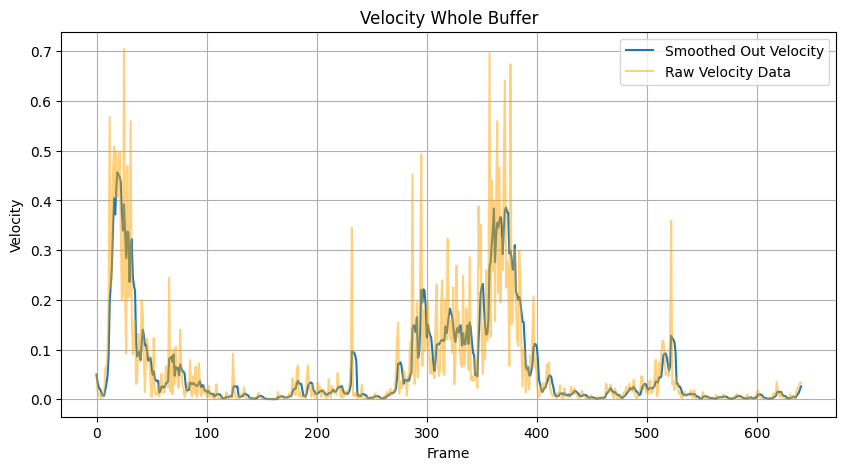

In [201]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(state_machine.velocity_whole_buffer, label='Smoothed Out Velocity')
plt.plot(s, alpha=0.5, label='Raw Velocity Data', color='orange')  # Lighter plot for noisy data
plt.title('Velocity Whole Buffer')
plt.xlabel('Frame')
plt.ylabel('Velocity')
plt.grid()
plt.legend()
plt.show()
